# PyTorch Custom Datasets

## 0. Importing PyTorch and setting up device-agnostic code

In [17]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision 
from torchvision import datasets 
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import torchmetrics
import torchmetrics

# Import plotting libraries
import matplotlib.pyplot as plt
import mlxtend

# Other imports
import requests
from pathlib import Path
import pandas as pd
import numpy as np
import random
import zipfile
import os
from PIL import Image

# Set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Check version
print(torch.__version__)
print(torchvision.__version__)
print(torchmetrics.__version__)
print(mlxtend.__version__)
print(device)

2.5.1
0.20.1
1.6.0
0.23.3
mps


## 1. Get data

Our dataset is a subset of the Food101 dataset. Food101 contains 101 different classes of food and 1000 images per class (750 training, 250 testing). Our dataset starts with 3 classes of food and 10% of the data (ca 75 training images, ca 25 testing images).

Why? In ML it is important to try things on a small scale and scale up when necessary, as it helps with faster experimentation.

In [7]:
# Set up path to data folder
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesn't exist, download and extract the data
if image_path.is_dir():
    print(f"{image_path} folder already exists, skipping download.")
else:
    print(f"{image_path} folder does not exist, creating it.")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak and sushi images
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading dataset...")
    f.write(response.content)
    
# Unzip files
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping dataset...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi folder already exists, skipping download.
Unzipping dataset...


## 2. Becoming one with the data aka data preparation and data exploration

In [9]:
def walk_through_dir(dir_path: Path):
    """
    Walks through dir_path returning its contents.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [10]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [11]:
# Setup training and test data directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all the image training paths
2. Pick a random image using `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open the image with PIL
5. We 'll show the image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


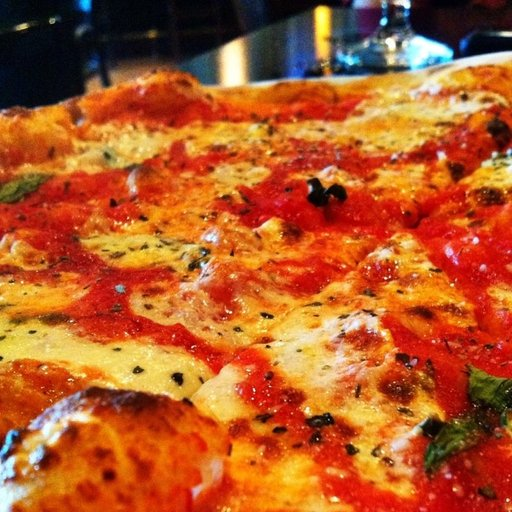

In [16]:
# Set seed
random.seed(42)
#1. Get all the image training paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
#2. Pick a random image using `random.choice()`
random_image_path = random.choice(image_path_list)
#3. Get the image class name using `pathlib.Path.parent.stem`
image_class = random_image_path.parent.stem
#4. Since we are working with images, let's open the image with PIL
img = Image.open(random_image_path)
#5. We 'll show the image and print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

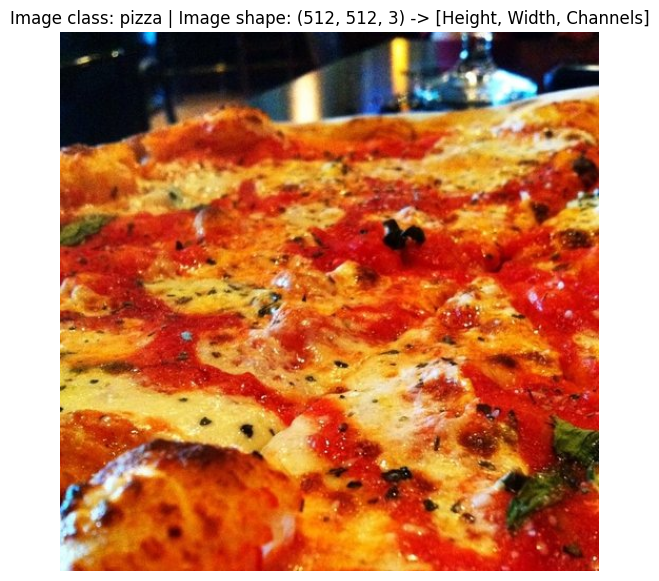

In [19]:
# Turn image into an array
img_array = np.asarray(img)

# Plot image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape: {img_array.shape} -> [Height, Width, Channels]")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with Pytorch: 
1. Turn your target data into tensors
2. Turn it in a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

### 3.1 Transforming data with `torchvision.transforms`

In [20]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize image to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the image horizontally (randomly with a 50% chance)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor
    transforms.ToTensor()
])

In [22]:
data_transform(img)

tensor([[[0.1020, 0.1922, 0.2314,  ..., 0.0118, 0.0157, 0.0157],
         [0.1216, 0.1059, 0.1137,  ..., 0.0157, 0.0157, 0.0157],
         [0.1569, 0.1255, 0.1098,  ..., 0.0941, 0.0235, 0.0157],
         ...,
         [0.6902, 0.6353, 0.4353,  ..., 0.8039, 0.8275, 0.8549],
         [0.7412, 0.6235, 0.4824,  ..., 0.7922, 0.8392, 0.8667],
         [0.8000, 0.6549, 0.6627,  ..., 0.7255, 0.7333, 0.8627]],

        [[0.0392, 0.0471, 0.0510,  ..., 0.0392, 0.0510, 0.0588],
         [0.0549, 0.0431, 0.0431,  ..., 0.0431, 0.0471, 0.0549],
         [0.0510, 0.0471, 0.0510,  ..., 0.1176, 0.0706, 0.0667],
         ...,
         [0.0627, 0.0627, 0.1098,  ..., 0.8118, 0.8824, 0.9529],
         [0.2353, 0.0824, 0.0667,  ..., 0.6353, 0.8510, 0.9804],
         [0.3098, 0.0980, 0.0745,  ..., 0.3176, 0.5451, 0.9412]],

        [[0.0392, 0.0510, 0.0588,  ..., 0.0667, 0.0745, 0.1176],
         [0.0510, 0.0392, 0.0431,  ..., 0.0784, 0.0863, 0.1137],
         [0.0627, 0.0510, 0.0588,  ..., 0.1216, 0.0941, 0.

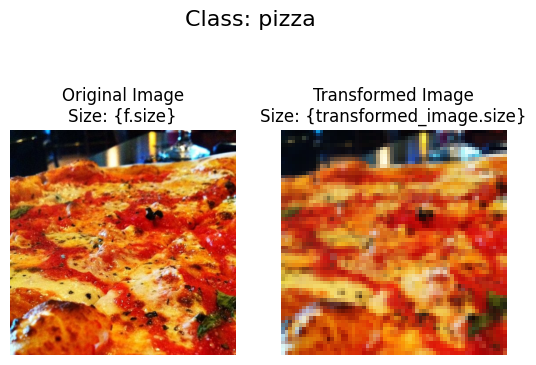

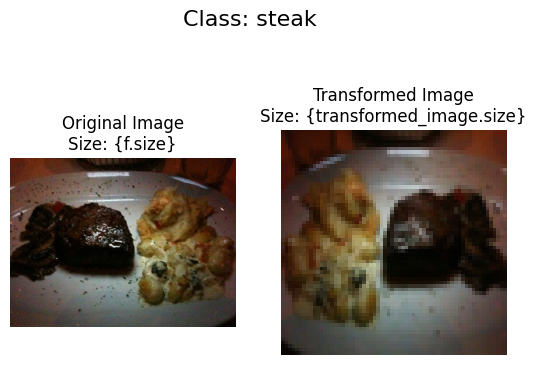

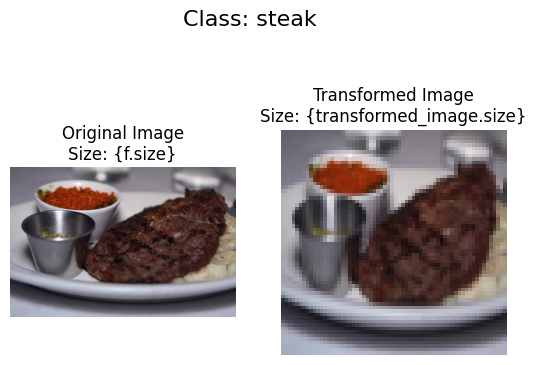

In [25]:
# Write function to plot original and transformed image
def plot_transformed_image(image_paths:list, transform, n=3, seed=None):
    """Selects image from image_paths and plots original and transformed image."""
    if seed:
        random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title("Original Image\nSize: {f.size}")
            ax[0].axis(False)
            
            # Transform and plot target image
            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title("Transformed Image\nSize: {transformed_image.size}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            
plot_transformed_image(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)